# TODO
- need all cells (ie non-MEL) to make argument for SC vs BULK analysis
- add cluster name annotations with developmental time ordering on top of res2 clusters
- plot MITF vs SOX2 over developmental time
- Better comparison to fetal expression??? Is there a more elegant way to show similarities? Perhaps, heat map of top DE genes?
- Coordinate with Ashley to have super meeting that includes bosses
- Velocyto on indir clusters with mixed days: melanoblasts?


# Setup

In [1]:
wkdir, s3dir = '/home/ubuntu/data/DL20190312_dish_mel', 'daniel.le-work/dish_MEL'
%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_all']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var


scanpy version: 1.3.3


In [2]:
# FUNCTIONS
from collections import defaultdict
import multiprocessing

def single_mwu(args):    
    # inputs
    gene_val, df1, df2, alt = args
    
    try:
        stat, pval = stats.mannwhitneyu(df1[gene_val].values,
                                        df2[gene_val].values, 
                                        alternative = alt
                                       )
    except:
        stat = np.nan
        pval = np.nan
    return (stat, pval)

def parallel_mwu(genes, df1, df2, method='two-sided', ncores=1):
    
    p = multiprocessing.Pool(processes=ncores)
    try:
        mwu_tuples = p.map(single_mwu, 
                                zip(genes,
                                    [df1]*len(genes),
                                    [df2]*len(genes),
                                    [method]*len(genes)
                                   ), 
                                chunksize=100)
    finally:
        p.close()
        p.join()

    stat_list = [x[0] for x in mwu_tuples]
    pval_list = [x[1] for x in mwu_tuples]
    return (stat_list, pval_list)

def disp_analysis(adata, min_mean=0.0125, max_mean=10, min_disp=0.1):
    
    print('Process expression data...')
    print('\tInitial:')
    sum_output(adata)
    
    tmp = sc.pp.normalize_per_cell(adata, copy=True)
    filter_result = sc.pp.filter_genes_dispersion(tmp.X, 
                                                  min_mean=min_mean, 
                                                  max_mean=max_mean, 
                                                  min_disp=min_disp)
    tmp = tmp[:, filter_result.gene_subset]
    
    print('Filtered cells: {}'.format(len(adata.obs) - len(tmp.obs)))
    print('Filtered genes: {}'.format(len(adata.var_names) - len(tmp.var_names)))
    print('\tResult:')
    sum_output (tmp)
    
    return tmp

## Ingest data

In [3]:
run_me = False

if run_me == True:

    ### TRUNK ###

    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_D0_COI.h5ad'
    adata_d0 = ad.read_h5ad(filename)

    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_D6_COI.h5ad'
    adata_d6 = ad.read_h5ad(filename)

    # merge trunk
    adata_trunk = adata_d0.concatenate(adata_d6, join='outer')

    # update meta data with path and day
    adata_trunk.obs['path'] = 'trunk'
    adata_trunk.obs['path'] = adata_trunk.obs['path'].astype(str).astype(CategoricalDtype(['trunk']))
    adata_trunk.obs['day'] = [int(x.split('d')[-1]) for x in adata_trunk.obs['sample']]

    # prune genes by dispersion
    adata_trunk = disp_analysis(adata_trunk)

    ### DIRECT ###

    # original
    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_dir_all_COI.h5ad'
    adata_dir = ad.read_h5ad(filename)

    # replacement d15
    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_dir_D15v2_COI.h5ad'
    adata_d15v2_dir = ad.read_h5ad(filename)

    # remove old d15 and replace with new
    adata_dir = adata_dir[adata_dir.obs['sample'] != 'd15_dir']
    adata_dir = adata_dir.concatenate(adata_d15v2_dir, join='outer')

    # update meta data with path and day
    adata_dir.obs['path'] = 'direct'
    adata_dir.obs['path'] = adata_dir.obs['path'].astype(str).astype(CategoricalDtype(['direct']))
    adata_dir.obs['day'] = [int(x.split('_')[0].split('d')[-1]) for x in adata_dir.obs['sample']]

    # add trunk
    adata_full_dir = adata_dir.concatenate(adata_trunk, join='outer')

    # prune genes by dispersion
    adata_full_dir = disp_analysis(adata_full_dir)

    ### INDIRECT ###

    # original
    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_indir_all_COI.h5ad'
    adata_indir = ad.read_h5ad(filename)

    # update meta data with path and day
    adata_indir.obs['path'] = 'indirect'
    adata_indir.obs['path'] = adata_indir.obs['path'].astype(str).astype(CategoricalDtype(['indirect']))
    adata_indir.obs['day'] = [int(x.split('_')[0].split('d')[-1]) for x in adata_indir.obs['sample']]

    # add trunk
    adata_full_indir = adata_indir.concatenate(adata_trunk, join='outer')

    # prune genes by dispersion
    adata_full_indir = disp_analysis(adata_full_indir)

    ### ALL ###

    # merge all
    adata_all = adata_trunk.concatenate(adata_dir, adata_indir, join='outer')

    # prune genes by dispersion
    adata_all = disp_analysis(adata_all)

    # update meta data with path and day
    adata_all.obs['path'] = adata_all.obs['path'].astype(str).astype(CategoricalDtype(['indirect','direct','trunk']))

    # freeze raw counts and scale
    # adata_all.X = sparse.csr_matrix(np.round(np.exp(adata_all.X.toarray())) - 1, dtype = np.float64)
    adata_all.raw = adata_all
    # sc.pp.log1p(adata_all)
    sc.pp.scale(adata_all)

    # UMAP and PCA
    input_adata = adata_all
    pca_adata(input_adata, num_pcs=25)
    umap_adata(input_adata, res=0.15, scan = False)

    # pickle adatas
    for objname in ['adata_all']:
        pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
        syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
        subprocess.run(syscmd.split(' '))


# PCA

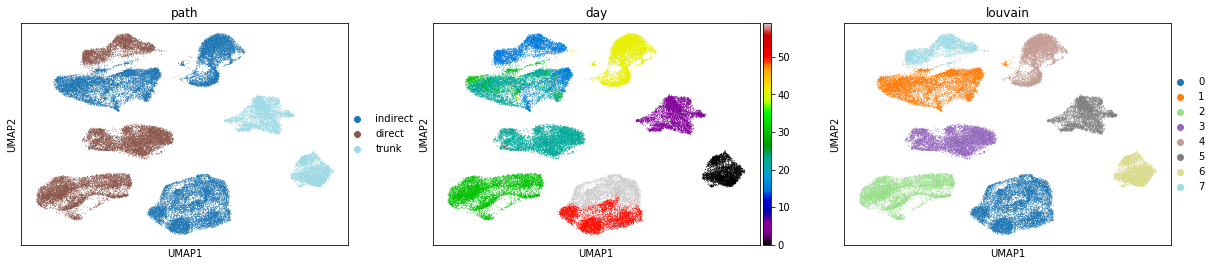

In [86]:
# sanity check
sc.pl.umap(adata_all, color = ['path', 'day','louvain'], palette = 'tab20', cmap = 'nipy_spectral')

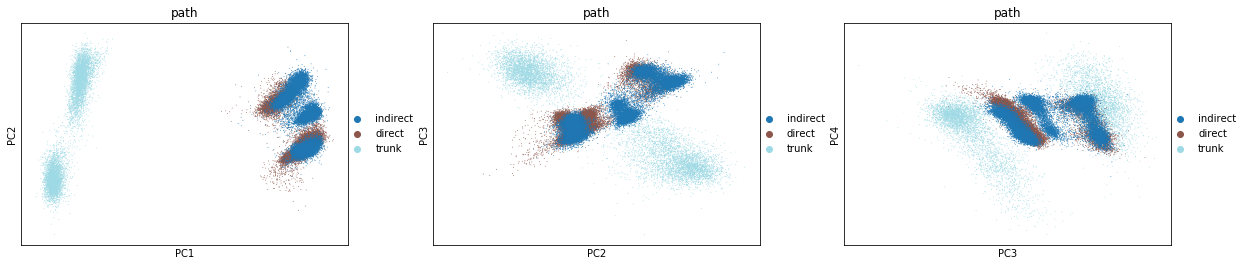

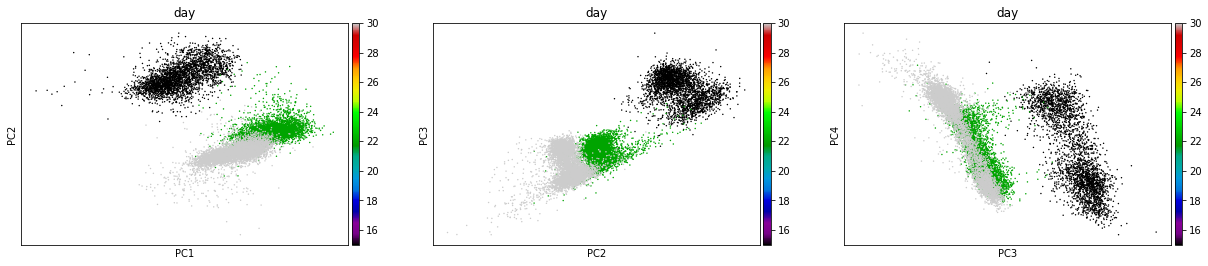

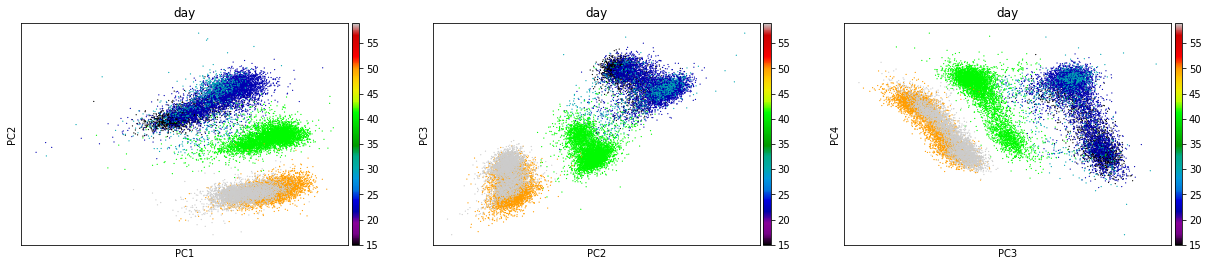

In [21]:
components = ['1,2','2,3','3,4']
sc.pl.pca(adata_all, color = ['path'], components=components, palette = 'tab20')
sc.pl.pca(adata_all[adata_all.obs.path == 'direct'], color = ['day'], components=components, cmap = 'nipy_spectral')
sc.pl.pca(adata_all[adata_all.obs.path == 'indirect'], color = ['day'], components=components, cmap = 'nipy_spectral')



# Differential expression: path-specific terminally-differentiated

## Bulkized ranked correlation

### All-clusters correlation

In [90]:
cat, adata_louvain_df = prepare_dataframe(adata_all,
                                         genes,
                                        'louvain',
                                         use_raw = True)
cluster_labels = {'0':'indir_d50_59',
                  '1':'indir_d15_22_30',
                  '2':'dir_d30',
                  '3':'dir_d22',
                  '4':'indir_d41',
                  '5':'trunk_d6',
                  '6':'truck_d0',
                  '7':'dir_d15'
                 }
corr_df = (adata_louvain_df
           .reset_index()
           .groupby('louvain')
           .mean()
           .T
           .rename(columns = cluster_labels)
          )

plot_df = corr_df.corr().reset_index().rename(columns = {'louvain':'cluster'})
plot_df = pd.melt(plot_df, id_vars='cluster')
plot_df['label'] = [round(x,1) for x in plot_df.value]

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('cluster','louvain',fill='value'))
      + geom_text(aes('cluster','louvain',label='label'), color = 'grey')
      + scale_fill_cmap('magma')
     )

#### Only terminally-differentiated clusters

bulkized spearman: SpearmanrResult(correlation=0.9094070737686717, pvalue=0.0)


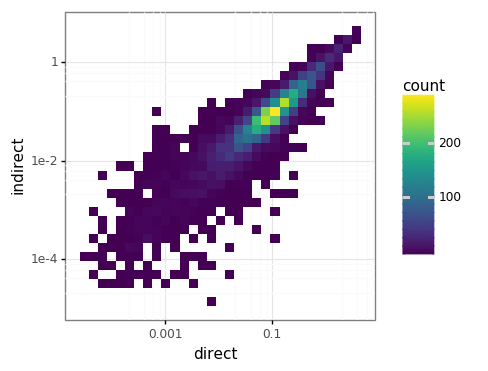

<ggplot: (8788077630079)>


In [52]:
adata_dir_d30 = adata_all[[x == 30 and y == 'direct' for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
adata_indir_d50_59 = adata_all[[x >= 50 and y == 'indirect' for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
genes = list(set(adata_dir_d30.var_names) & set(adata_indir_d50_59.var_names))

cat, adata_dir_d30_df = prepare_dataframe(adata_dir_d30,
                                         genes,
                                        'path',
                                         use_raw = True)
cat, adata_indir_d50_59_df = prepare_dataframe(adata_indir_d50_59,
                                         genes,
                                        'path',
                                         use_raw = True)

# bulkized correlation
print('bulkized spearman:', stats.spearmanr(adata_dir_d30_df.mean().values, adata_indir_d50_59_df.mean().values))
plot_df = pd.DataFrame({'direct': adata_dir_d30_df.mean().values,
                        'indirect': adata_indir_d50_59_df.mean().values
                       })
print(ggplot(plot_df)
      + theme_bw()
      + geom_bin2d(aes('direct', 'indirect'))
      + scale_y_log10()
      + scale_x_log10()
     )


## Single-cell ranked location test

In [63]:
for i in ['greater', 'less']:
    print(f'direct {i} than indirect:')
    if i == 'greater':
        ascending = False
    else:
        ascending = True
    stat_pval_tuple = parallel_mwu(genes, 
                                   adata_dir_d30_df.rank(pct=True, axis = 1, method = 'min'), 
                                   adata_indir_d50_59_df.rank(pct=True, axis = 1, method = 'min'), 
                                   i, 
                                   7)
    stat_list = stat_pval_tuple[0]
    pval_list = stat_pval_tuple[1]
    mwu_pathspecific = (pd.DataFrame({'gene':genes,
                             'stat_1':stat_list,
                             'pval_1':pval_list
                            })
              )

    display(mwu_pathspecific.dropna().sort_values('stat_1', ascending = ascending).head(10))

direct greater than indirect:


,gene,stat_1,pval_1
2032,NMRK2,41736897.0,0.0
1928,CAPG,41144851.5,0.0
1021,STMN1,40756721.5,0.0
1937,AKAP12,40352875.0,0.0
1974,SPP1,39993994.5,0.0
2183,TAX1BP1,39286108.0,0.0
1601,TMSB4X,38107476.0,0.0
2205,UGCG,36834558.5,0.0
122,ACSL3,36254081.5,0.0
1114,SEPP1,35866330.0,0.0


direct less than indirect:


,gene,stat_1,pval_1
1531,MFSD12,2570237.0,0.0
81,RPS27,5604911.5,0.0
1926,S100B,5881768.0,0.0
1648,LGALS3,6543147.5,0.0
2317,TSPO,6956249.5,0.0
903,SLC7A8,7582373.5,0.0
1075,LINC00152,9069410.5,0.0
393,IFITM3,10183713.0,0.0
1557,MIR4435-2HG,10184425.5,0.0
97,HERPUD1,10747377.5,0.0


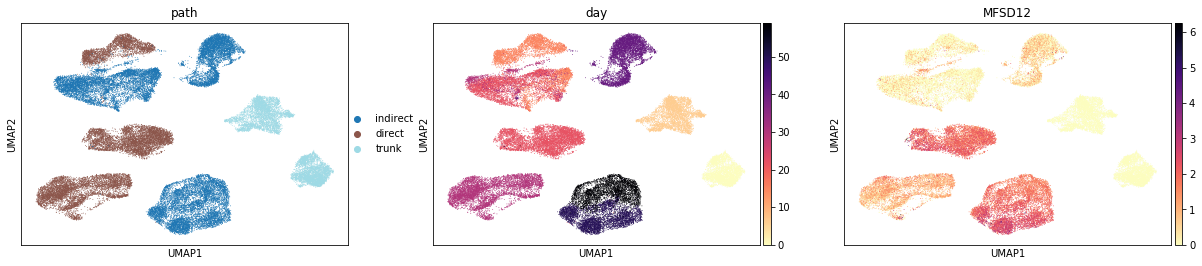

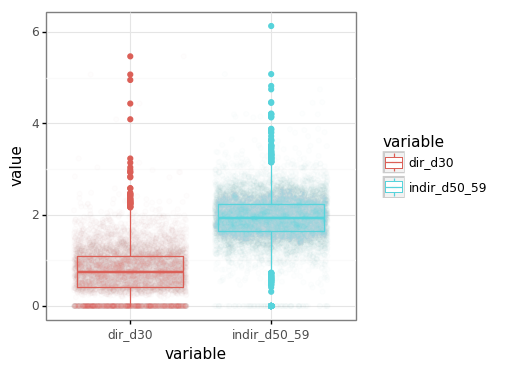

<ggplot: (8788075891997)>
querying 1-1...done.
Finished.
0:  MFSD12 
 N/A


In [54]:
gene = 'MFSD12'

sc.pl.umap(adata_all, color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')

plot_df = pd.DataFrame({'value':adata_dir_d30_df[gene].values,
                        'variable':'dir_d30'
                       }).append(pd.DataFrame({'value':adata_indir_d50_59_df[gene].values,
                                               'variable':'indir_d50_59'
                                              }))

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + geom_boxplot(aes('variable','value', color = 'variable'))
      + geom_jitter(aes('variable','value', color = 'variable'), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


# Comparison to primary melanocytes

## Bulkized ranked correlation

In [11]:
## read in adata with fetal melanocytes = adata_subset2
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'
for file in ['adata_subset2']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

adata_subset2.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in adata_subset2.obs.age]
adata_subset2.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in adata_subset2.obs.general_location]
adata_subset2.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(adata_subset2.obs.dev_stage, adata_subset2.obs.subtypes)]


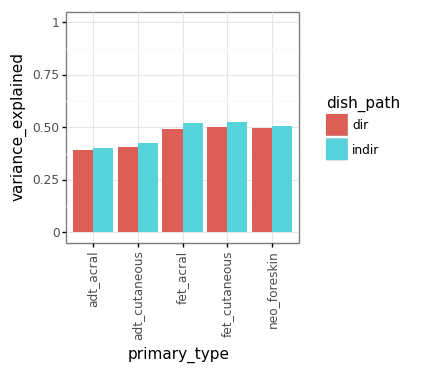

<ggplot: (8787993679687)>


In [41]:
# bulk-ize terminal direct and indirect...spearman correlation to bulkized fetal
genes = list(set(adata_subset2.var_names) & set(adata_all.var_names))
input_adata = adata_subset2

# create expression vector for dir path
    cat, adata_dir_d30_df = prepare_dataframe(adata_dir_d30,
                                             genes,
                                            'path',
                                             use_raw = True)
    adata_dir_d30_vec = adata_dir_d30_df.mean().values
    
# create expression vector for indir path
cat, adata_indir_d50_59_df = prepare_dataframe(adata_indir_d50_59,
                                         genes,
                                        'path',
                                         use_raw = True)
adata_indir_d50_59_vec = adata_indir_d50_59_df.mean().values

path_list = []
devtype_list = []
stat_list = []
for i in list(set(adata_subset2.obs.dev_subtype)):
    input_adata = adata_subset2[adata_subset2.obs.dev_subtype == i]
    
    # create expression vector for primary
    cat, adata_subset2_df = prepare_dataframe(input_adata,
                                             genes,
                                            'patient',
                                             use_raw = True)
    adata_subset2_vec = adata_subset2_df.mean().values
    
    for j in [adata_dir_d30_vec, adata_indir_d50_59_vec]:
        if j is adata_dir_d30_vec:
            path = 'dir'
        else:
            path = 'indir'
        stat, pval = stats.spearmanr(adata_subset2_vec, j)
        path_list.append(path)
        devtype_list.append(i)
        stat_list.append(stat)
        
plot_df = pd.DataFrame({'dish_path':path_list,
                        'primary_type':devtype_list,
                        'rho':stat_list
                       })
plot_df['variance_explained'] = plot_df.rho**2
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_bar(aes('primary_type','variance_explained',fill='dish_path'), 
                 stat = 'identity', 
                 position = 'dodge')
      + ylim((0,1))
     )


##  Single cell ranked location test

In [169]:
### refactor for different primary tissues ###
dev_stage = 'adt'
# dev_stage = 'neo'
# dev_stage = 'fet'
print(f'Primary melanocyte developmental state: {dev_stage}')

primary_adata = adata_subset2[adata_subset2.obs.dev_stage == dev_stage]
genes = list(set(primary_adata.var_names) & set(mwu_pathspecific.gene))
cat, primary_slice = prepare_dataframe(primary_adata,
                                     var_names = genes,
                                     groupby = 'patient')

alpha = 0.05
adj_alpha = alpha / (len(genes) * 2)

for test in ['greater', 'less']:
    print(f'direct {test} than indirect:')
    if test == 'greater':
        ascending = False
    else:
        ascending = True
    
    # stat_1 = direct vs indirect
    stat_pval_tuple = parallel_mwu(genes, 
                                   adata_dir_d30_df.rank(pct=True, axis = 1, method = 'min'), 
                                   adata_indir_d50_59_df.rank(pct=True, axis = 1, method = 'min'), 
                                   test, 
                                   7)
    stat_list = stat_pval_tuple[0]
    pval_list = stat_pval_tuple[1]
    mwu_pathspecific = (pd.DataFrame({'gene':genes,
                             'stat_1':stat_list,
                             'pval_1':pval_list
                            })
              )
    
    # stat_2 = direct vs primary OR indirect vs primary
    path_specific_df = pd.DataFrame()
    for path in ['direct', 'indirect']:
        if path == 'direct':
            slice_df = adata_dir_d30
        elif path == 'indirect':
            slice_df = adata_indir_d50_59
        cat, prep_slice = prepare_dataframe(slice_df,
                                         var_names = genes,
                                         groupby = 'path')

        stat_pval_tuple = parallel_mwu(genes, 
                                   primary_slice.rank(pct=True, axis = 1, method = 'min'), 
                                   prep_slice.rank(pct=True, axis = 1, method = 'min'), 
                                   test,
                                   7)
        stat_list = stat_pval_tuple[0]
        pval_list = stat_pval_tuple[1]
        tmp_df = (pd.DataFrame({'gene':genes,
                                 'stat_2':stat_list,
                                 'pval_2':pval_list
                                })
                  )
        tmp_df['path'] = path
        tmp_df['pass'] = [x < adj_alpha for x in tmp_df['pval_2']]
        path_specific_df = path_specific_df.append(tmp_df)

    path_specific_df = pd.merge(mwu_pathspecific, path_specific_df, 'left', 'gene')
    path_specific_df = path_specific_df.dropna().sort_values('stat_1', ascending=ascending)
    keep_genes = path_specific_df.groupby('gene')['pass'].sum()
    keep_genes = keep_genes[keep_genes == 1].index.tolist()
    path_specific_df = path_specific_df[[x in keep_genes for x in path_specific_df.gene]]
    display(path_specific_df.head(10))


Primary melanocyte developmental state: adt
direct greater than indirect:


,gene,stat_1,pval_1,stat_2,pval_2,path,pass
3856,CAPG,41144851.5,0.0,8056520.0,1.000000e+00,direct,False
3857,CAPG,41144851.5,0.0,17175941.5,0.000000e+00,indirect,True
3875,AKAP12,40352875.0,0.0,19461642.0,0.000000e+00,indirect,True
3874,AKAP12,40352875.0,0.0,7752650.5,1.000000e+00,direct,False
4366,TAX1BP1,39286108.0,0.0,4395126.0,1.000000e+00,direct,False
4367,TAX1BP1,39286108.0,0.0,14946796.0,1.489625e-107,indirect,True
1724,PLP1,35100524.0,0.0,6147322.0,1.000000e+00,direct,False
1725,PLP1,35100524.0,0.0,12862911.5,1.464100e-12,indirect,True
424,SERPINE2,35065407.0,0.0,5148344.0,1.000000e+00,direct,False
425,SERPINE2,35065407.0,0.0,12522455.5,1.416788e-06,indirect,True


direct less than indirect:


,gene,stat_1,pval_1,stat_2,pval_2,path,pass
3297,LGALS3,6543147.5,0.0,7735534.0,6.602750e-175,indirect,True
3296,LGALS3,6543147.5,0.0,12511801.5,1.000000e+00,direct,False
1807,SLC7A8,7582373.5,0.0,11153557.5,1.043164e-06,indirect,True
1806,SLC7A8,7582373.5,0.0,12681079.5,1.000000e+00,direct,False
787,IFITM3,10183713.0,0.0,7431918.0,2.884078e-201,indirect,True
786,IFITM3,10183713.0,0.0,10912413.0,1.000000e+00,direct,False
195,HERPUD1,10747377.5,0.0,6583761.5,1.132260e-289,indirect,True
194,HERPUD1,10747377.5,0.0,8764746.0,1.078210e-01,direct,False
2194,MYC,11434273.0,0.0,9169641.5,9.996451e-01,direct,False
2195,MYC,11434273.0,0.0,6996473.5,1.126942e-274,indirect,True


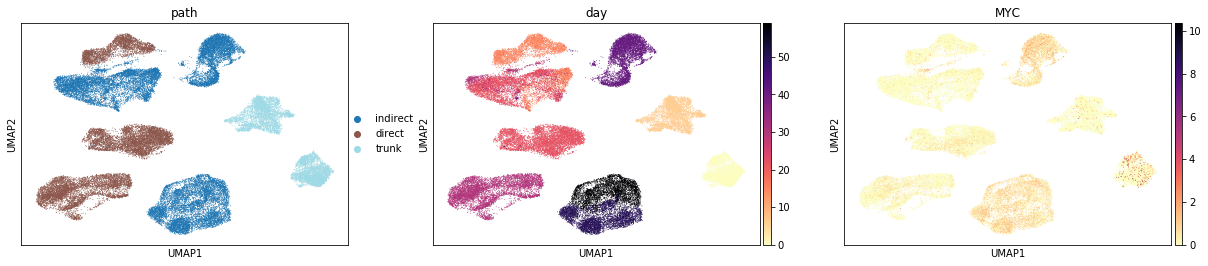

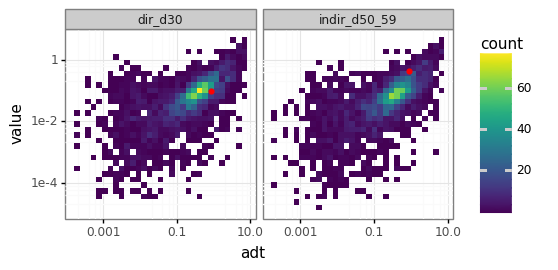

<ggplot: (-9223363248767507438)>


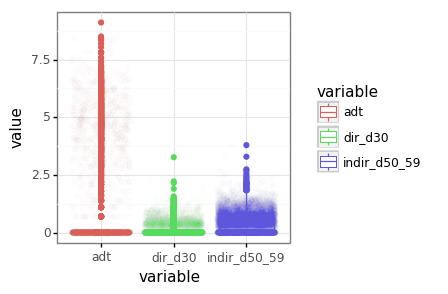

<ggplot: (-9223363248737218665)>
querying 1-1...done.
Finished.
0:  MYC 
 This gene is a proto-oncogene and encodes a nuclear phosphoprotein that plays a role in cell cycle progression, apoptosis and cellular transformation. The encoded protein forms a heterodimer with the related transcription factor MAX. This complex binds to the E box DNA consensus sequence and regulates the transcription of specific target genes. Amplification of this gene is frequently observed in numerous human cancers. Translocations involving this gene are associated with Burkitt lymphoma and multiple myeloma in human patients. There is evidence to show that translation initiates both from an upstream, in-frame non-AUG (CUG) and a downstream AUG start site, resulting in the production of two isoforms with distinct N-termini. [provided by RefSeq, Aug 2017].


In [171]:
###### gene lookup

gene = 'MYC'

sc.pl.umap(adata_all, color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')

plot_df = (pd.DataFrame({'value':adata_dir_d30_df[gene].values,
                        'variable':'dir_d30'
                       })
           .append(pd.DataFrame({'value':adata_indir_d50_59_df[gene].values,
                                 'variable':'indir_d50_59'
                                              }))
           .append(pd.DataFrame({'value':primary_slice[gene].values,
                                 'variable':dev_stage
                                  }))
           
                        )

point_df = pd.DataFrame(plot_df[plot_df['variable'] != dev_stage].groupby('variable').mean())
point_df[dev_stage] = primary_slice.loc[:,gene].mean()
point_df = point_df.reset_index()

bulkize_df = pd.DataFrame({dev_stage:primary_slice.mean().values, 
                          'dir_d30':adata_dir_d30_vec,
                          'indir_d50_59':adata_indir_d50_59_vec})
bulkize_df = pd.melt(bulkize_df, id_vars=dev_stage)

plotnine.options.figure_size = (5,5)
print(ggplot()
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_bin2d(bulkize_df, aes(dev_stage,'value'))
      + geom_point(point_df, aes(dev_stage, 'value'), color = 'red')
      + facet_wrap('~variable')
      + scale_x_log10()
      + scale_y_log10()
     )

plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
      + theme_bw()
      + geom_boxplot(aes('variable','value', color = 'variable'))
      + geom_jitter(aes('variable','value', color = 'variable'), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


# DEV: velocyto

In [15]:
import loompy
import os
import scvelo as scv

In [16]:
run = False

filedir = '/home/ubuntu/data/DL20190312_dish_mel/velocyto/'
files = [''.join([filedir,x]) for x in os.listdir(filedir) if (x.endswith('.loom') and x != 'merged.loom')]
for x in files:
    print(x)

filename = '/home/ubuntu/data/DL20190312_dish_mel/velocyto/merged.loom'
if run == True:
    loompy.combine(files,filename,"Accession")


/home/ubuntu/data/DL20190312_dish_mel/velocyto/d15_dir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d6_trunk.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d15_indir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d22_indir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d0_trunk.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d41_indir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d22_dir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d59_indir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d30_dir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d50_indir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d30_indir.loom


In [180]:
adata = scv.read(filename, cache=True)
adata_velo_merge = scv.utils.merge(adata_all, adata)
basis = 'pca'

# subset
fltrd_velo = adata_velo_merge[[x=='indirect' and y >= 50 for x,y in zip(adata_velo_merge.obs.path, 
                                                                        adata_velo_merge.obs.day)]]

scv.pp.filter_and_normalize(fltrd_velo)
scv.pp.moments(fltrd_velo)
scv.tl.velocity(fltrd_velo)
scv.tl.velocity_graph(fltrd_velo)
scv.tl.velocity_embedding(fltrd_velo, basis=basis)


... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Normalized count data: X, spliced, unspliced.
Did not modify X as it looks preprocessed already.
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:06.55) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:05.06) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:01.45) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05.42) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01.77) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

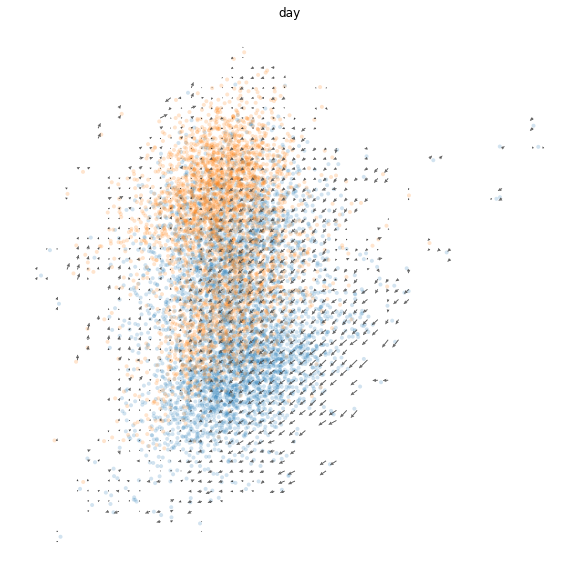

In [183]:
component = '2,3'

for pathoi in ['indirect']:
    scv.pl.velocity_embedding_grid(fltrd_velo[fltrd_velo.obs.path == pathoi], 
                                   basis=basis, 
                                   figsize = (10,10),
                                   components = component,
                                   color = ['day']
                                  )


# Deprecated

## Differential expression: d41 indirect (+dir_d22??)

### Single-cell ranked location test

In [9]:
# determine DE unique indirect cluster

adata_indir_d41 = adata_all[[x == 41 and y == 'indirect' for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
# non-trunk rest
adata_rest = adata_all[[x != 41 and y in ['indirect','direct'] for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
genes = list(set(adata_indir_d41.var_names) & set(adata_rest.var_names))

cat, adata_indir_d41_df = prepare_dataframe(adata_indir_d41,
                                         genes,
                                        'path',
                                         use_raw = True)
cat, adata_rest_df = prepare_dataframe(adata_rest,
                                         genes,
                                        'path',
                                         use_raw = True)

# mwu test: indir_d41 vs rest
stat_pval_tuple = parallel_mwu(genes, 
                               adata_indir_d41_df.rank(pct=True, axis = 1, method = 'min'), 
                               adata_rest_df.rank(pct=True, axis = 1, method = 'min'), 
                               'greater', 
                               7)
stat_list = stat_pval_tuple[0]
pval_list = stat_pval_tuple[1]
mwu_df1 = (pd.DataFrame({'gene':genes,
                         'stat_1':stat_list,
                         'pval_1':pval_list
                        })
          )

display(mwu_df1.dropna().sort_values('stat_1', ascending = False).head(10))


,gene,stat_1,pval_1
4346,LRRC75A-AS1,133691479.0,0.0
3991,EIF3E,130431341.5,0.0
1645,C6orf48,129296993.5,0.0
967,ITM2C,128050554.0,0.0
5708,CAV1,126905611.5,0.0
1436,EIF3L,125787749.0,0.0
299,GAS5,125166679.5,0.0
484,EIF3F,124665158.0,0.0
1667,IFITM3,118706927.5,0.0
3201,S100A6,118699487.5,0.0


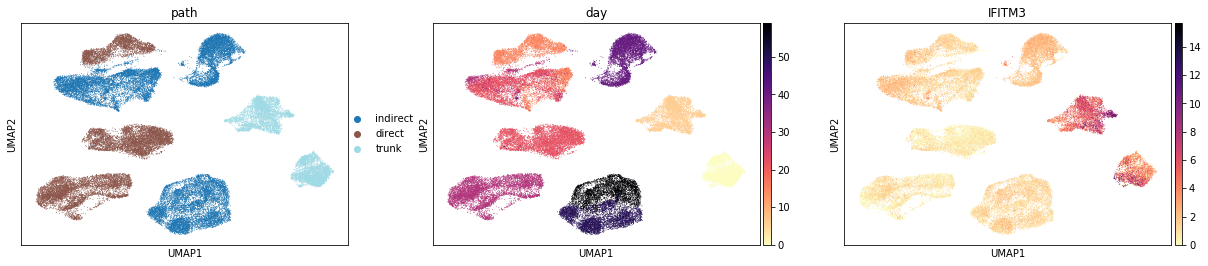

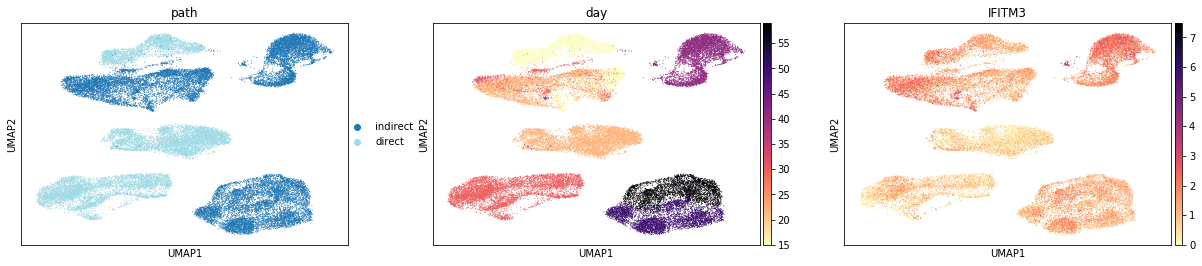

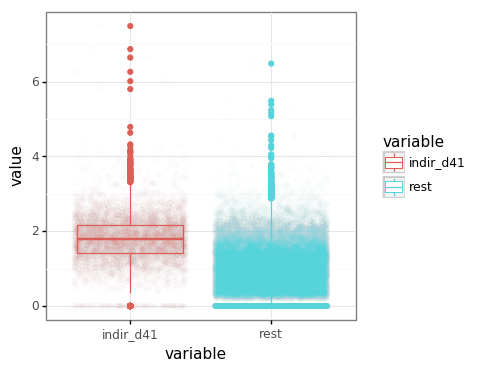

<ggplot: (-9223363248777135728)>
querying 1-1...done.
Finished.
0:  IFITM3 
 The protein encoded by this gene is an interferon-induced membrane protein that helps confer immunity to influenza A H1N1 virus, West Nile virus, and dengue virus. Two transcript variants, only one of them protein-coding, have been found for this gene. Another variant encoding an N-terminally truncated isoform has been reported, but the full-length nature of this variant has not been determined. [provided by RefSeq, May 2012].


In [22]:
gene = 'IFITM3'

sc.pl.umap(adata_all, color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')
sc.pl.umap(adata_all[adata_all.obs.path != 'trunk'], color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')

plot_df = pd.DataFrame({'value':adata_indir_d41_df[gene].values,
                        'variable':'indir_d41'
                       }).append(pd.DataFrame({'value':adata_rest_df[gene].values,
                                               'variable':'rest'
                                              }))

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + geom_boxplot(aes('variable','value', color = 'variable'))
      + geom_jitter(aes('variable','value', color = 'variable'), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]
